In [10]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [11]:
import numpy as np
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [312]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

<IPython.core.display.Javascript object>

In [13]:
colors = ["#035afc", "#56fc03", "#fc0303", "#fff6a6"]
values = [1, 2, 3, 4]

norm = mpl.colors.Normalize(vmin=min(values), vmax=max(values))
normed_vals = norm(values)

cmap = LinearSegmentedColormap.from_list(
    "mypalette", list(zip(normed_vals, colors)), N=1000
)

vec_func = np.vectorize(lambda l: 4 if l == 0 else l)

font = {"weight": "bold", "size": 22}
mpl.rc("font", **font)

<IPython.core.display.Javascript object>

### Specific cmap

# Question 1 :  Undestanding MDPs

Const init

In [14]:
CID = "1797836"
gamma = 1
S = ["s1", "s2", "s3"]

<IPython.core.display.Javascript object>

In [15]:
cid = list(map(int, [k for k in CID]))

<IPython.core.display.Javascript object>

### Trace and reward

In [16]:
states = [(k + 2) % 3 for k in cid]
reward = [l % 2 for l in cid]
combined = list(zip(states, reward))

<IPython.core.display.Javascript object>

In [17]:
trace = [f"s_{state} {reward} " for state, reward in combined]
print(f"Trace is: {''.join(trace)[:-1]}")

Trace is: s_0 1 s_0 1 s_2 1 s_0 1 s_1 0 s_2 1 s_2 0


<IPython.core.display.Javascript object>

## TD

In [20]:
v_td = [0, 0, 0]
alpha = 0.3
for k in range(len(states) - 1):
    d = reward[k] + gamma * v_td[states[k + 1]] - v_td[states[k]]
    v_td[states[k]] = v_td[states[k]] + alpha * d

<IPython.core.display.Javascript object>

In [21]:
print(
    "".join(
        [
            f"State s_{k} has estimated value {v_td[k]} with TD\n"
            for k in range(len(v_td))
        ]
    )
)

State s_0 has estimated value 0.657 with TD
State s_1 has estimated value 0.1359 with TD
State s_2 has estimated value 0.7529999999999999 with TD



<IPython.core.display.Javascript object>

## MC

In [22]:
def tomap(l, R):
    R[l].append(reward[l])

<IPython.core.display.Javascript object>

In [23]:
R = [[], [], []]
list(map(lambda l: tomap(l, R), states))
v_mc = [np.mean(l) for l in R]

<IPython.core.display.Javascript object>

In [24]:
print(
    "".join(
        [
            f"State s_{k} has estimated value {v_mc[k]} with MC\n"
            for k in range(len(v_mc))
        ]
    )
)

State s_0 has estimated value 1.0 with MC
State s_1 has estimated value 1.0 with MC
State s_2 has estimated value 1.0 with MC



<IPython.core.display.Javascript object>

# Question 2: Understanding of Grid Worlds

In [31]:
x = 8
y = 3
z = 6
reward_state = ((z + 1) % 3) + 1
reward_loc = (0, 1)

p = 0.25 + 0.5 * x / 10
gamma = 0.2 + 0.5 * y / 10

<IPython.core.display.Javascript object>

In [363]:
## Code heavily inspired and adapted from lab3
class GridWorld(object):
    def __init__(self, reward_loc=reward_loc, gamma=gamma, p=p):

        # Size of grid world
        self.shape = (4, 4)

        # Locations of the obstacles
        self.obstacle_locs = [(1, 2), (2, 0), (3, 1), (3, 3), (3, 0)]

        # Locations for the absorbing states
        self.absorbing_locs = [reward_loc, (3, 2)]

        # Rewards for each of the absorbing states
        self.special_rewards = {
            reward_loc: 10,
            (3, 2): -100,
        }  # corresponds to each of the absorbing_locs

        # Reward for all the other states
        self.default_reward = -1

        # Action names
        self.action_names = ["N", "E", "S", "W"]

        # Number of actions
        self.action_size = len(self.action_names)

        # Gamma
        self.gamma = gamma

        # Probability of action
        self.p = p
        self.p_other = (1 - p) / 3

        ############################################

        #### Internal State  ####

        # Get attributes defining the world
        state_size, T, R, absorbing, locs = self.build_grid_world()

        # Number of valid states in the gridworld (there are 22 of them)
        self.state_size = state_size

        # Transition operator (3D tensor)
        self.T = T

        # Reward function (3D tensor)
        self.R = R

        # Absorbing states
        self.absorbing = absorbing

        # The locations of the valid states
        self.locs = locs

        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape)
        for ob in self.obstacle_locs:
            self.walls[ob] = 1

        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1

        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for rew in self.special_rewards:
            self.rewarders[rew] = 2 if self.special_rewards[rew] > 0 else 3

        # Illustrating the grid world
        # self.paint_maps()
        ################################

    ####### Getters ###########

    def get_transition_matrix(self):
        return self.T

    def get_reward_matrix(self):
        return self.R

    ########################

    ####### Methods #########
    def value_iteration(self, threshold):
        """
        Value iteration to determine the best policy and the related value
        """
        # Make sure delta is bigger than the threshold to start with
        delta = 2 * threshold

        # Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()

        # Initialise policy
        policy = np.zeros(self.state_size)

        # The value is initialised at 0
        V = np.zeros(self.state_size)

        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.full(self.state_size, -np.inf)

        # While the Value has not yet converged do:
        while delta > threshold:
            for s in range(self.state_size):

                # Getting the max of value function according to better policy
                tmp_max = -np.inf
                best_action = 0

                for action in range(self.action_size):
                    tmp = 0
                    for s_posterior in range(self.state_size):
                        tmp += T[s_posterior, s, action] * (
                            R[s_posterior, s, action] + self.gamma * V[s_posterior]
                        )
                    if tmp >= tmp_max:
                        best_action = action
                        tmp_max = tmp

                Vnew[s] = tmp_max
                policy[s] = best_action

            #             print("---")
            #             print(f"Vnew = {Vnew}")
            #             print(f"V = {V}")
            #             print(f"policy= {policy}")
            #             print("\n\n\n")

            delta = max(abs(Vnew - V))

            V = np.copy(Vnew)

        return V, policy.astype(int)

    ##########################

    ########### Internal Helper Functions #####################
    def paint_maps(self):
        plt.figure(figsize=(15, 15))
        plt.subplot(1, 3, 1)
        plt.imshow(self.walls)
        plt.subplot(1, 3, 2)
        plt.imshow(self.absorbers)
        plt.subplot(1, 3, 3)
        plt.imshow(self.rewarders)
        plt.show()

    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbours, absorbing = self.get_topology()

        # Get the number of states
        S = len(locations)

        # Initialise the transition matrix
        T = self.build_transition_matrix(S, neighbours)

        # Build the reward matrix
        R = self.build_reward_matrix(S, locations)

        return S, T, R, absorbing, locations

    def build_reward_matrix(self, S, locations):
        """
        Build the reward matrix of GridWorld
        R[posterior, prior, action] 
        Example:
            R[11, 10, 2] is the reward from state s10 to s_11
            action 2
        """

        # Build the reward matrix
        R = self.default_reward * np.ones((S, S, 4))

        for loc in self.special_rewards:
            post_state = self.loc_to_state(loc, locations)
            R[post_state, :, :] = self.special_rewards[loc]

        return R

    def build_transition_matrix(self, S, neighbours):
        """
        Build the transition matrix of GridWorld
        """

        # Initialise the transition matrix
        T = np.zeros((S, S, 4))

        for prior_state in range(S):
            for action in range(4):  # N E S W
                main_action_state = neighbours[prior_state, action]
                T[main_action_state, prior_state, action] += self.p  # / occ

                other_action_state = [
                    l for l in neighbours[prior_state] if l != main_action_state
                ]

                if len(other_action_state) != 3:
                    T[main_action_state, prior_state, action] += (
                        3 - len(other_action_state)
                    ) * self.p_other

                for other_state in other_action_state:
                    T[other_state, prior_state, action] += self.p_other

        # Absorbing states
        T[:, 1] = np.zeros((11, 4))
        T[:, 10] = np.zeros((11, 4))

        return T

    def get_topology(self):
        """
        locs : list of valid locations
        state_neighbours: matrix number_state X number_actions
                          line ==> state
                          column ==> action (N, E, S, W)
        absorbing : list of absobing states
                    index ==> state
                    value ==> if 1 then absorbing state
        """
        height = self.shape[0]
        width = self.shape[1]

        index = 1
        locs = []
        neighbour_locs = []

        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i, j)

                # And append it to the valid state locations if it is a valid state (ie not absorbing)
                if self.is_location(loc):
                    locs.append(loc)

                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [
                        self.get_neighbour(loc, direction)
                        for direction in ["nr", "ea", "so", "we"]
                    ]
                    neighbour_locs.append(local_neighbours)

        # translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states, 4))

        for state in range(num_states):
            for direction in range(4):
                # Find neighbour location
                nloc = neighbour_locs[state][direction]

                # Turn location into a state number
                nstate = self.loc_to_state(nloc, locs)

                # Insert into neighbour matrix
                state_neighbours[state, direction] = int(nstate)

        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1, num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a, locs)
            absorbing[0, absorbing_state] = 1
        return locs, state_neighbours.astype(int), absorbing

    def loc_to_state(self, loc, locs):
        # takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))

    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if (
            loc[0] < 0
            or loc[1] < 0
            or loc[0] > self.shape[0] - 1
            or loc[1] > self.shape[1] - 1
        ):
            return False
        elif loc in self.obstacle_locs:
            return False
        else:
            return True

    def get_neighbour(self, loc, direction):
        # Find the valid neighbours (ie that are in the grid and not obstacle)
        i = loc[0]
        j = loc[1]

        nr = (i - 1, j)
        ea = (i, j + 1)
        so = (i + 1, j)
        we = (i, j - 1)

        # If the neighbour is a valid location, accept it, otherwise, stay put
        if direction == "nr" and self.is_location(nr):
            return nr
        elif direction == "ea" and self.is_location(ea):
            return ea
        elif direction == "so" and self.is_location(so):
            return so
        elif direction == "we" and self.is_location(we):
            return we
        else:
            # default is to return to the same location
            return loc

    ###########################################

    def draw_policy(self, policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure(figsize=(20, 15))

        plt.imshow(vec_func(self.walls + self.rewarders), cmap=cmap)
        for state, action in enumerate(policy):
            if self.absorbing[0, state]:
                continue
            arrows = [r"$\uparrow$", r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
            action_arrow = f"{arrows[action]}\n $S_{state}$"
            location = self.locs[state]
            plt.text(location[1], location[0], action_arrow, ha="center", va="center")
        plt.axis("off")
        legend_elements = [
            Patch(facecolor="#035afc", edgecolor="#035afc", label="Wall"),
            Patch(
                facecolor="#56fc03",
                edgecolor="#56fc03",
                label="Terminal state\nReward 10",
            ),
            Patch(
                facecolor="#fc0303",
                edgecolor="#fc0303",
                label="Terminal state\nReward -100",
            ),
            Patch(facecolor="#fff6a6", edgecolor="#fff6a6", label="Possible state"),
        ]
        plt.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))
        plt.title(
            f"Policy representation for $\gamma={self.gamma}$ and $p={self.p}$", y=1.03
        )
        plt.savefig("template/policy")
        plt.show()

    def draw_value_function(self, V):

        plt.figure(figsize=(20, 15))

        plt.imshow(vec_func(self.walls + self.rewarders), cmap=cmap)
        for state, action in enumerate(V):
            if self.absorbing[0, state]:
                continue
            action_arrow = f"$V(S_{state})={V[state]:.2f}$"
            location = self.locs[state]
            plt.text(location[1], location[0], action_arrow, ha="center", va="center")
        plt.axis("off")
        legend_elements = [
            Patch(facecolor="#035afc", edgecolor="#035afc", label="Wall"),
            Patch(
                facecolor="#56fc03",
                edgecolor="#56fc03",
                label="Terminal state\nReward 10",
            ),
            Patch(
                facecolor="#fc0303",
                edgecolor="#fc0303",
                label="Terminal state\nReward -100",
            ),
            Patch(facecolor="#fff6a6", edgecolor="#fff6a6", label="Possible state"),
        ]
        plt.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))
        plt.title(
            f"Policy representation for $\gamma={self.gamma}$ and $p={self.p}$", y=1.03
        )
        plt.savefig("template/value_function")
        plt.show()

<IPython.core.display.Javascript object>

In [364]:
g = GridWorld()
V, pol = g.value_iteration(1e-5)

<IPython.core.display.Javascript object>

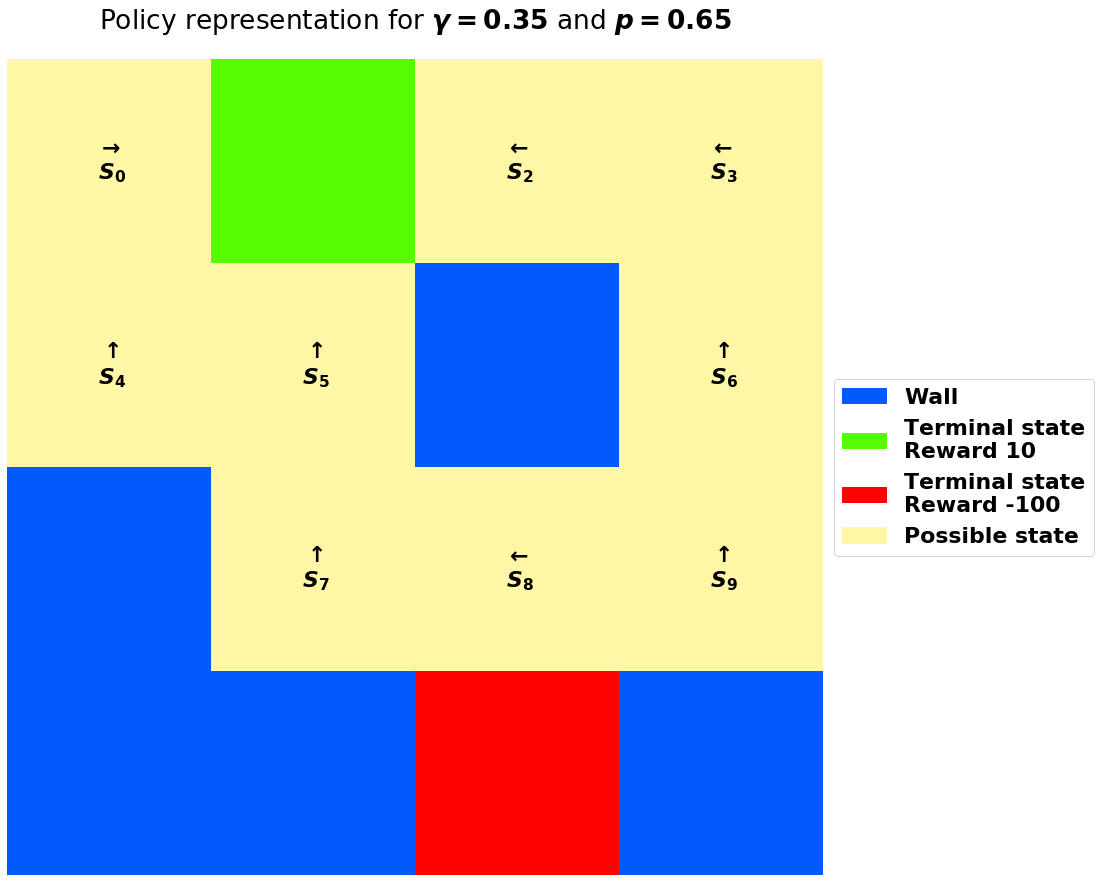

<IPython.core.display.Javascript object>

In [365]:
g.draw_policy(pol)

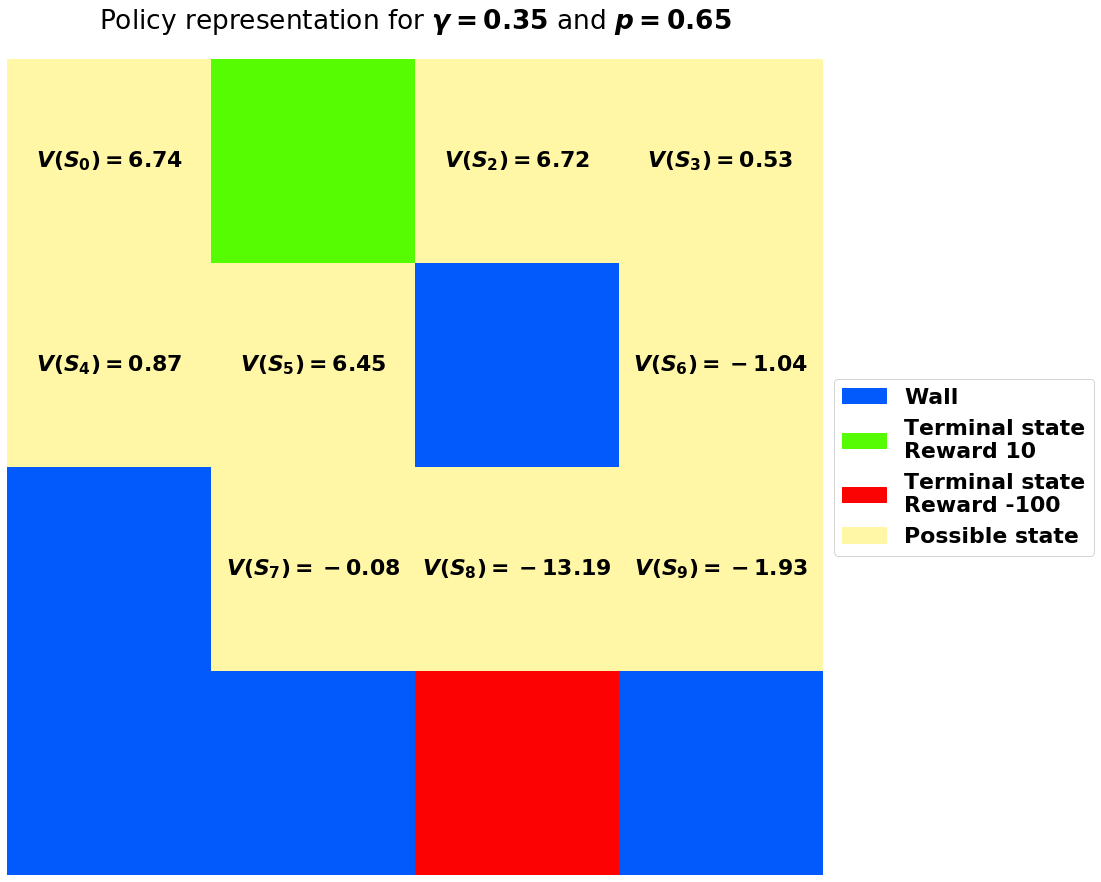

<IPython.core.display.Javascript object>

In [366]:
g.draw_value_function(V)

In [50]:
img = g.walls + g.rewarders
vec_func(img)

array([[4, 2, 4, 4],
       [4, 4, 1, 4],
       [1, 4, 4, 4],
       [1, 1, 3, 1]])

<IPython.core.display.Javascript object>

In [51]:
def paint_maps(self):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(self.walls)
    plt.subplot(1, 3, 2)
    plt.imshow(self.absorbers)
    plt.subplot(1, 3, 3)
    plt.imshow(self.rewarders)
    plt.show()

<IPython.core.display.Javascript object>

In [52]:
colors = ["#035afc", "#56fc03", "#fc0303", "#fff6a6"]
values = [1, 2, 3, 4]

norm = mpl.colors.Normalize(vmin=min(values), vmax=max(values))
normed_vals = norm(values)

cmap = LinearSegmentedColormap.from_list(
    "mypalette", list(zip(normed_vals, colors)), N=1000
)

<IPython.core.display.Javascript object>

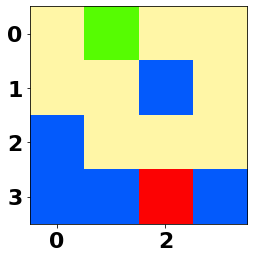

<IPython.core.display.Javascript object>

In [53]:
plt.imshow(vec_func(img), cmap=cmap)